## **SKYBUG INTERNSHIP**

## **AI INTERN**

## **TASK - 3**

## **Done By : A S V Dhanush**


*This code is done in collab as my computer coannot hold the computational power of ResNet And LSTM model*

Importing the relevant libraries

In [1]:
#importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from tqdm.notebook import tqdm
tqdm.pandas()
import cv2, warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from keras.layers import Dense, Flatten, Input, Add, Dropout, LSTM, TimeDistributed, Embedding, RepeatVector, Concatenate, Bidirectional, Convolution2D
from keras.models import Sequential, Model
from keras.applications import ResNet50
from keras.utils import to_categorical, plot_model
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading the images

In [3]:
img_path = '/content/drive/MyDrive/SKYBUG_INTERNSHIP/dataset/Images/'
images = glob(img_path+'*.jpg')
images[:5]

['/content/drive/MyDrive/SKYBUG_INTERNSHIP/dataset/Images/3744832122_2f4febdff6.jpg',
 '/content/drive/MyDrive/SKYBUG_INTERNSHIP/dataset/Images/397725001_e51f7c391c.jpg',
 '/content/drive/MyDrive/SKYBUG_INTERNSHIP/dataset/Images/375392855_54d46ed5c8.jpg',
 '/content/drive/MyDrive/SKYBUG_INTERNSHIP/dataset/Images/390671130_09fdccd52f.jpg',
 '/content/drive/MyDrive/SKYBUG_INTERNSHIP/dataset/Images/386656845_4e77c3e3da.jpg']

In [4]:
len(images)

8091

### **Taking the captions**

In [5]:
captions = open('/content/drive/MyDrive/SKYBUG_INTERNSHIP/dataset/captions.txt','rb').read().decode('utf-8').split('\n')
captions[:5]

['image,caption',
 '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .']

In [6]:
len(captions)

40457

### **Visualizing images along with their captions**

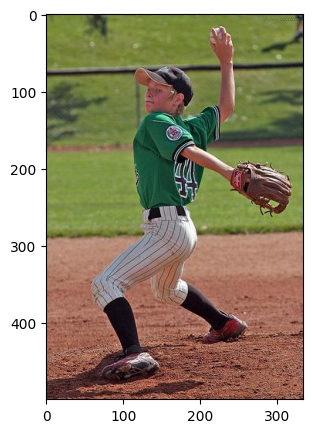

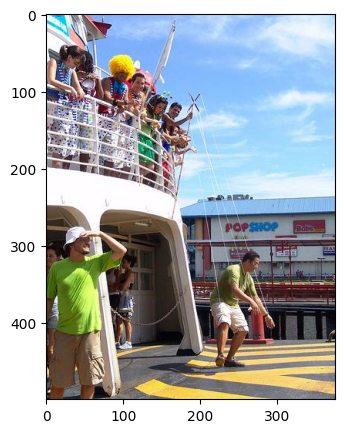

In [7]:
for i in range(2):
    plt.figure(figsize=(5,5))
    img = cv2.imread(images[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img);

### **Using ResNet50 model**

In [8]:
resnet_model = ResNet50(include_top=True)
# resnet_model.summary()

In [9]:
fe = resnet_model.layers[-2].output # Output of the penultimate layer of ResNet model
model= Model(inputs=resnet_model.input,outputs=fe)
# model.summary()

### **Extracting features from images**

In [10]:
img_features = {}
count = 0

for img_path in tqdm(images[:1251]):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(224,224))     # ResNet model requires images of dimensions (224,224,3)
    img = img.reshape(1,224,224,3)
    features = model.predict(img).reshape(2048,)
    img_name = img_path.split('/')[-1]
    img_features[img_name] = features
    count += 1
    # Fetching the features of only 1250 images as using more than 1250 images leads to overloading memory issues
    if count == 1250:
        break

  0%|          | 0/1251 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


### Storing the features

In [11]:
import pickle
with open('features_RESNET50.pkl','wb') as f:
  pickle.dumps(img_features)

In [12]:
len(img_features)

1250

## **Preprocessing the captions text**

In [13]:
captions = captions[1:]
captions[:5]

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .']

In [14]:
captions_dict = {}

for cap in captions:
    try:
        img_name = cap.split(',')[0]
        caption = cap.split(',')[1]
        # Each image has 5 captions
        if img_name in img_features:
            if img_name not in captions_dict:
                captions_dict[img_name] = [caption] # Storing the first caption
            else:
                captions_dict[img_name].append(caption) # Adding the remaining captions
    except:
        break

In [15]:
def preprocess(text):
    modified_text = text.lower() # Converting text to lowercase
    modified_text = 'startofseq ' + modified_text + ' endofseq' # Appending the special tokens at the beginning and ending of text
    return modified_text

In [16]:
# Storing the preprocessed text within the captions dictionary
for key, val in captions_dict.items():
    for item in val:
        captions_dict[key][val.index(item)] = preprocess(item)

### **Creating vocabulary of the entire text corpus**

In [17]:
count_words = dict()
cnt = 1

for key, val in captions_dict.items(): # Iterating through all images with keys as images and their values as 5 captions
    for item in val: # Iterating through all captions for each image
        for word in item.split(): # Iterating through all words in each caption
            if word not in count_words:
                count_words[word] = cnt
                cnt += 1

In [18]:
len(count_words) # Vocab size

3544

In [19]:
# Encoding the text by assigning each word to its corresponding index in the vocabulary i.e. count_words dictionary
for key, val in captions_dict.items():
    for caption in val:
        encoded = []
        for word in caption.split():
            encoded.append(count_words[word])
        captions_dict[key][val.index(caption)] = encoded

In [20]:
# Determining the maximum possible length of text within the entire captions text corpus
max_len = -1

for key, value in captions_dict.items():
    for caption in value:
        if max_len < len(caption):
            max_len = len(caption)

In [21]:
max_len

34

In [22]:
vocab_size = len(count_words) # Vocab size is the total number of words present in count_words dictionary
vocab_size

3544

#### **Building a custom generator function to generate input image features, previously generated text and the text to be generated as output**

In [23]:
def train_test_split(img,caption):
    n_samples = 0
    X = []
    y_input = []
    y_output = []

    for key, val in caption.items():
        for item in val:
            for i in range(1,len(item)):
                X.append(img[key]) # Appending the input image features
                input_seq = [item[:i]] # Previously generated text to be used as input to predict the next word
                output_seq = item[i] # The next word to be predicted as output
                # Padding encoded text sequences to the maximum length
                input_seq = pad_sequences(input_seq,maxlen=max_len,padding='post',truncating='post')[0]
                # One Hot encoding the output sequence with vocabulary size as the total no. of classes
                output_seq = to_categorical([output_seq],num_classes=vocab_size+1)[0]
                y_input.append(input_seq)
                y_output.append(output_seq)

    return X, y_input, y_output

In [24]:
X, y_in, y_out = train_test_split(img_features,captions_dict)

In [25]:
len(X), len(y_in), len(y_out)

(76662, 76662, 76662)

In [26]:
# Converting input and output into Numpy arrays for faster processing
X = np.array(X)
y_in = np.array(y_in,dtype='float64')
y_out = np.array(y_out,dtype='float64')

In [27]:
X.shape, y_in.shape, y_out.shape

((76662, 2048), (76662, 34), (76662, 3545))

### **Model**

In [28]:
embedding_len = 128
MAX_LEN = max_len
vocab_size = len(count_words)

# Model for image feature extraction
img_model = Sequential()
img_model.add(Dense(embedding_len,input_shape=(2048,),activation='relu'))
img_model.add(RepeatVector(MAX_LEN))



# Model for generating captions from image features
captions_model = Sequential()
captions_model.add(Embedding(input_dim=vocab_size+1,output_dim=embedding_len,input_length=MAX_LEN))
captions_model.add(LSTM(128,return_sequences=True))
captions_model.add(TimeDistributed(Dense(embedding_len)))


# Concatenating the outputs of image and caption models
concat_output = Concatenate()([img_model.output,captions_model.output])
# First LSTM Layer
output = LSTM(units=128,return_sequences=True)(concat_output)
# Second LSTM Layer
output = LSTM(units=256,return_sequences=False)(output)
# Output Layer
output = Dense(units=vocab_size+1,activation='softmax')(output)
# Creating the final model
final_model = Model(inputs=[img_model.input,captions_model.input],outputs=output)
final_model.compile(loss='categorical_crossentropy',optimizer='RMSprop',metrics='accuracy')
# final_model.summary()

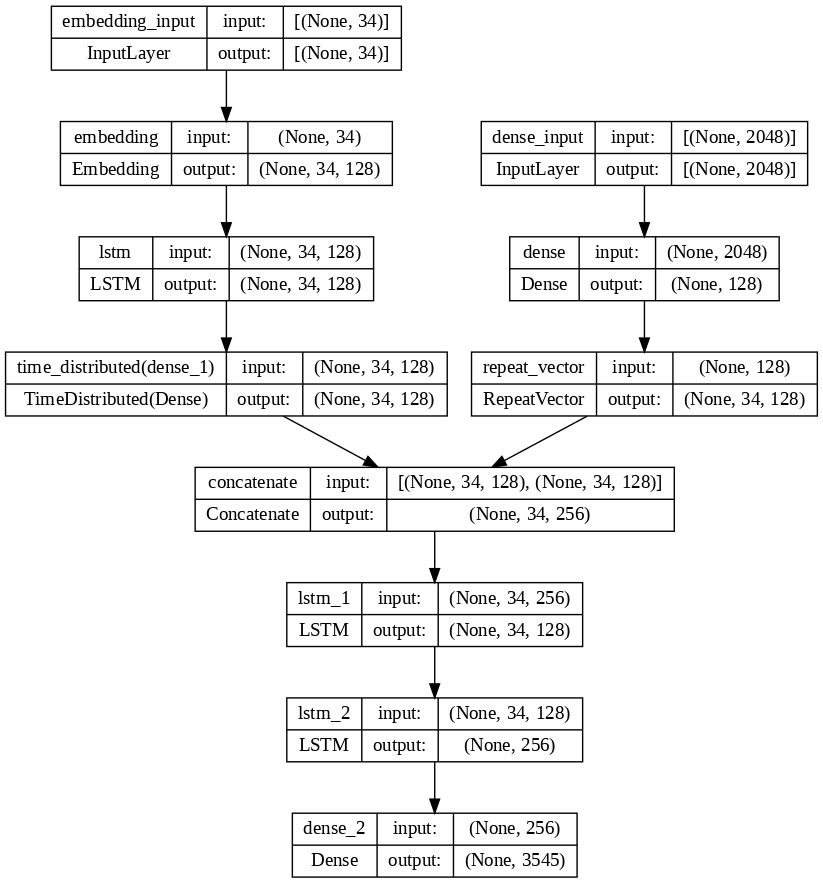

In [29]:
plot_model(final_model,'model.png',show_shapes=True,dpi=100)

In [30]:
final_model.fit([X,y_in],
                y_out,
                batch_size=32,
                epochs=20)

Epoch 1/20
2396/2396 [==============================] - 42s 15ms/step - loss: 5.2652 - accuracy: 0.1189
Epoch 2/20
2396/2396 [==============================] - 31s 13ms/step - loss: 5.1950 - accuracy: 0.1204
Epoch 3/20
2396/2396 [==============================] - 32s 14ms/step - loss: 5.1580 - accuracy: 0.1194
Epoch 4/20
2396/2396 [==============================] - 31s 13ms/step - loss: 5.1305 - accuracy: 0.1194
Epoch 5/20
2396/2396 [==============================] - 31s 13ms/step - loss: 5.1125 - accuracy: 0.1202
Epoch 6/20
2396/2396 [==============================] - 31s 13ms/step - loss: 5.0855 - accuracy: 0.1197
Epoch 7/20
2396/2396 [==============================] - 31s 13ms/step - loss: 5.0700 - accuracy: 0.1203
Epoch 8/20
2396/2396 [==============================] - 31s 13ms/step - loss: 5.0510 - accuracy: 0.1202
Epoch 9/20
2396/2396 [==============================] - 31s 13ms/step - loss: 5.0300 - accuracy: 0.1196
Epoch 10/20
2396/2396 [==============================] - 36s 15m

In [34]:
# Reversing Key value pairs
reversed_index = {val: key for key,val in count_words.items()}

### **Generating For Testing Images**

In [35]:
# Function To Preprocess test image
def preprocess_test_image(idx):
    test_img_path = images[idx]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img,(224,224))
    test_img = np.reshape(test_img,(1,224,224,3))
    return test_img

1/1 [==============================] - 0s 19ms/step


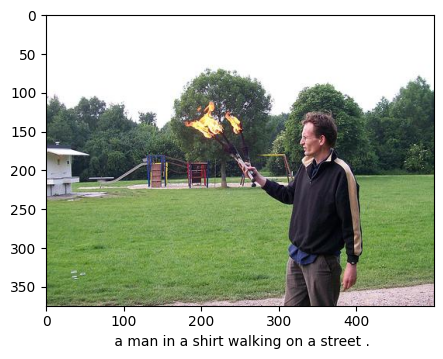

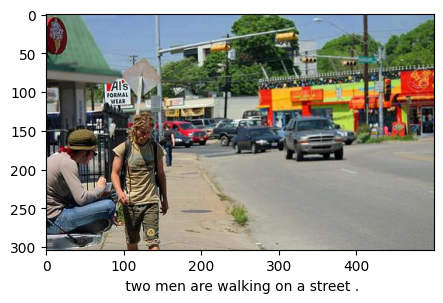

In [39]:
for i in range(2):
    random_no = np.random.randint(0,1251,(1,1))[0,0]
    test_feature = model.predict(preprocess_test_image(random_no)).reshape(1,2048)
    test_img_path = images[random_no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    pred_text = ['startofseq']
    count = 0
    caption = '' # Stores the predicted captions text

    while count < 25:
        count += 1
        # Encoding the captions text with numbers
        encoded = []

        for i in pred_text:
            encoded.append(count_words[i])

        encoded = [encoded]
        # Padding the encoded text sequences to maximum length
        encoded = pad_sequences(encoded,maxlen=MAX_LEN,padding='post',truncating='post')
        pred_idx = np.argmax(final_model.predict([test_feature,encoded])) # Fetching the predicted word index having the maximum probability of occurrence
        sampled_word = reversed_index[pred_idx] # Extracting the predicted word by its respective index
        # Checking for ending of the sequence
        if sampled_word == 'endofseq':
            break
        caption = caption + ' ' + sampled_word
        pred_text.append(sampled_word)

    plt.figure(figsize=(5,5))
    plt.imshow(test_img)
    plt.xlabel(caption)

### **Since The Number of Epochs and the number of images are limited to a few, we can see that the model is not quite accurate but predict some instances like 'dog' etc**

### **We can imporve this model by increasing the dataset and also by using more LSTM layers (But needs Computataion Power**